## Importing Libraries

In [21]:
# Importing Libraries
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sn

import skimage.io

import keras.backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

## **Extracting the data**

Download and place the FER-2013 dataset and name it as fer2013 if you are running locally.   
Upload the zipped file named fer2013.zip to the directory of your notebook if you are running on Colab.

In [5]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
 extracting: fer2013/train/sad/Training_65267116.jpg  
 extracting: fer2013/train/sad/Training_65275626.jpg  
 extracting: fer2013/train/sad/Training_6529266.jpg  
 extracting: fer2013/train/sad/Training_65329617.jpg  
 extracting: fer2013/train/sad/Training_65338712.jpg  
 extracting: fer2013/train/sad/Training_65338797.jpg  
 extracting: fer2013/train/sad/Training_65387162.jpg  
 extracting: fer2013/train/sad/Training_65404494.jpg  
 extracting: fer2013/train/sad/Training_65426218.jpg  
 extracting: fer2013/train/sad/Training_65430136.jpg  
 extracting: fer2013/train/sad/Training_65437377.jpg  
 extracting: fer2013/train/sad/Training_6545735.jpg  
 extracting: fer2013/train/sad/Training_65463385.jpg  
 extracting: fer2013/train/sad/Training_65473985.jpg  
 extracting: fer2013/train/sad/Training_65502829.jpg  
 extracting: fer2013/train/sad/Training_65505359.jpg  
 extracting: fer2013/train/sad/Training_65508578.jpg  
 extracting: fer

## **Importing Training and Test Data**

In [45]:
# Defining Training data generator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     validation_split = 0.2,
                                     rotation_range=5,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     shear_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     fill_mode='nearest')
# Defining Validation data generator
val_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)
# Defining Test data generator
test_generator = ImageDataGenerator(rescale = 1./255)

In [48]:
D = 48
batch_size = 32

# Importing Training Data from directory
train_data = train_generator.flow_from_directory(directory = 'fer2013/train',
                                                 target_size = (D,D),
                                                 class_mode = 'categorical',
                                                 subset = 'training',
                                                 batch_size = batch_size)
# Importing Validation Data from directory
val_data = val_generator.flow_from_directory(directory = 'fer2013/train',
                                             target_size = (D,D),
                                             class_mode = 'categorical',
                                             subset = 'validation',
                                             batch_size = batch_size)
# Importing Test Data from directory
test_data = test_generator.flow_from_directory(directory = 'fer2013/test',
                                               target_size = (D,D),
                                               class_mode = 'categorical',
                                               batch_size = batch_size)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## **Necessary Functions**

In [49]:
def plot_learning_curve(n_epochs, history):
    '''
    This function plots the learning curve.
    '''
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(n_epochs)

    plt.figure(figsize=(14,7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.axis([-0.25,n_epochs,0,1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axis([-0.25, n_epochs, 0, max(max(val_loss), max(loss))+0.25])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## **Building the Model**

In [8]:
# Importing the VGG16 pre-trained model with Imagenet weights
base_model = tf.keras.applications.VGG16(input_shape=(D,D,3), include_top=False, weights="imagenet")

# Freezing Layers
for layer in base_model.layers[:-14]:
    layer.trainable = False

base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [9]:
# Building the Model
Emotion_model = Sequential([
    
    base_model,
    Dropout(0.5),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(32,kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(32,kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(32,kernel_initializer='he_uniform'),
    BatchNormalization(),
    Activation('relu'),
    
    Dense(7,activation='softmax')
])

Emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [61]:
Emotion_model = tf.keras.models.load_model('Emotion Model.h5')

In [62]:
dynamic_lr = ReduceLROnPlateau(monitor = 'val_loss',
                        patience = 20,
                        verbose = 1,
                        factor = 0.5,
                        min_lr = 1e-5)

model_cp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [63]:
Emotion_model.compile(optimizer='Adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history = Emotion_model.fit(train_data,
                            validation_data=val_data,
                            epochs = 100,
                            verbose = 1,
                            callbacks=[dynamic_lr, model_cp, es])

Epoch 1/100
718/718 [==============================] - 37s 42ms/step - loss: 1.0961 - accuracy: 0.5946 - val_loss: 1.1589 - val_accuracy: 0.5776 - lr: 0.0010
Epoch 2/100
718/718 [==============================] - 30s 42ms/step - loss: 1.0942 - accuracy: 0.5964 - val_loss: 1.1687 - val_accuracy: 0.5719 - lr: 0.0010
Epoch 3/100
718/718 [==============================] - 30s 42ms/step - loss: 1.0812 - accuracy: 0.6018 - val_loss: 229.0370 - val_accuracy: 0.5811 - lr: 0.0010
Epoch 4/100
718/718 [==============================] - 30s 42ms/step - loss: 1.0840 - accuracy: 0.6044 - val_loss: 245.1171 - val_accuracy: 0.5687 - lr: 0.0010
Epoch 5/100
718/718 [==============================] - 30s 42ms/step - loss: 1.1404 - accuracy: 0.5815 - val_loss: 1570.1980 - val_accuracy: 0.5792 - lr: 0.0010
Epoch 6/100
718/718 [==============================] - 30s 42ms/step - loss: 1.0928 - accuracy: 0.5974 - val_loss: 1.1903 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 7/100
718/718 [========================

In [68]:
Emotion_model.save('Emotion Model.h5')


Training completed in  50 epochs
The Accuracy on Validation Dataset is: 60.69%


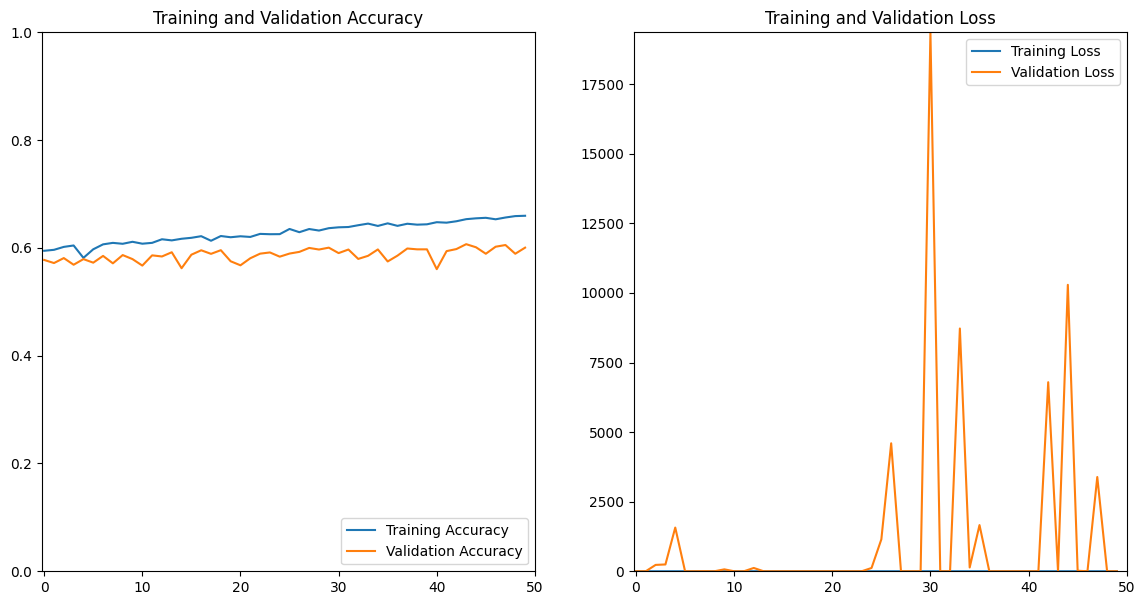

In [65]:
n_epochs = len(history.history['loss'])
print("\nTraining completed in ", n_epochs, "epochs")
print('The Accuracy on Validation Dataset is: %.2f%%'%(np.max(history.history['val_accuracy'])*100))

# Plotting the learning curve
plot_learning_curve(n_epochs, history.history)

### **Testing**

In [64]:
loss, acc = Emotion_model.evaluate(test_data, steps=len(test_data), verbose=1)

print(f'Test loss = {loss:.2f}')
print(f'Test Accuracy = {acc*100:.2f}%')

225/225 [==============================] - 3s 13ms/step - loss: 1.0749 - accuracy: 0.6240
Test loss = 1.07
Test Accuracy = 62.40%
